# **Segmentation models comparison**

# Check masking

In [ ]:
!pip install pycocotools

In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown --id 1BZTU8Gyg20wqHXtBPFzRazn_lEdvhsbE

In [ ]:
!pip install patool
import patoolib

path = "./HRSID_JPG.rar"
patoolib.extract_archive(path, outdir="./")

In [6]:
image_directory = 'HRSID_JPG/JPEGImages/'
annotation_file = 'HRSID_JPG/annotations/train2017.json'

In [ ]:
example_coco = COCO(annotation_file)

In [8]:
categories = example_coco.loadCats(example_coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

Custom COCO categories: 
ship



In [9]:
category_ids = example_coco.getCatIds()
image_ids = example_coco.getImgIds(catIds=category_ids)
image_data = example_coco.loadImgs(image_ids[np.random.randint(0, len(image_ids))])[0]

In [10]:
image_data

{'date_captured': None,
 'file_name': 'P0072_600_1400_3600_4400.jpg',
 'height': 800,
 'id': 2366,
 'license': 0,
 'url': None,
 'width': 800}

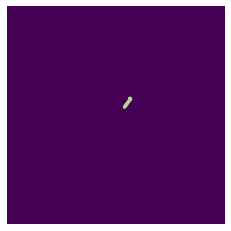

In [11]:
image = io.imread(image_directory + image_data['file_name'])
plt.imshow(image); plt.axis('off')
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
annotation_ids = example_coco.getAnnIds(imgIds=image_data['id'], catIds=category_ids, iscrowd=None)
annotations = example_coco.loadAnns(annotation_ids)
example_coco.showAnns(annotations)

mask = example_coco.annToMask(annotations[0])
for i in range(len(annotations)):
    mask = np.maximum(example_coco.annToMask(annotations[i]), mask)

plt.imshow(mask)

# Data processing

In [ ]:
!pip install -q git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI
from pathlib import Path
import random
from typing import Any, Callable, List, Optional, Tuple

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import io, transforms
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm

In [13]:
ROOT_PATH = Path('./HRSID_JPG')
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 10
NUM_WORKERS = 2
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
PIN_MEMORY = True
LOAD_MODEL = False
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

In [ ]:
train_annotations = COCO(ROOT_PATH / "annotations/train2017.json")
valid_annotations = COCO(ROOT_PATH / "annotations/test2017.json")

In [24]:
cat_ids_t = train_annotations.getCatIds()
train_img_ids = []
for cat in cat_ids_t:
    train_img_ids.extend(train_annotations.getImgIds(catIds=cat))
    
train_img_ids = list(set(train_img_ids))
print(f"Number of training images: {len(train_img_ids)}")

cat_ids_v = valid_annotations.getCatIds()
valid_img_ids = []
for cat in cat_ids_v:
    valid_img_ids.extend(valid_annotations.getImgIds(catIds=cat))
    
test_img_ids = list(set(valid_img_ids))[1500:]
valid_img_ids = list(set(valid_img_ids))[:1500]

print(f"Number of validation images: {len(valid_img_ids)}")
print(f"Number of test images: {len(test_img_ids)}")

Number of training images: 3642
Number of validation images: 1500
Number of test images: 461


In [22]:
class ImageData(Dataset):
    def __init__(self, annotations: COCO, img_ids: List[int], cat_ids: List[int], root_path: Path, transform: Optional[Callable]=None) -> None:
        super().__init__()
        self.annotations = annotations
        self.img_data = annotations.loadImgs(img_ids)
        self.cat_ids = cat_ids
        self.files = [str(root_path / img["file_name"]) for img in self.img_data]
        self.transform = transform
        
    def __len__(self) -> int:
        return len(self.files)
    
    def __getitem__(self, i: int) -> Tuple[torch.Tensor, torch.LongTensor]:
        ann_ids = self.annotations.getAnnIds(
            imgIds=self.img_data[i]['id'], 
            catIds=self.cat_ids, 
            iscrowd=None
        )
        anns = self.annotations.loadAnns(ann_ids)
        mask = torch.LongTensor(np.max(np.stack([self.annotations.annToMask(ann) * ann["category_id"] 
                                                 for ann in anns]), axis=0)).unsqueeze(0)
        
        img = io.read_image(self.files[i])
        if img.shape[0] == 1:
            img = torch.cat([img]*3)
        
        if self.transform is not None:
            return self.transform(img, mask)
        
        return img, mask

### Augmentation

In [23]:
def train_transform( img1: torch.LongTensor, img2: torch.LongTensor):
    params = transforms.RandomResizedCrop.get_params(img1, scale=(0.5, 1.0), ratio=(0.75, 1.33))
    
    img1 = TF.resized_crop(img1, *params, size=IMAGE_SIZE)
    img2 = TF.resized_crop(img2, *params, size=IMAGE_SIZE)
    
    if random.random() > 0.5:
        img1 = TF.hflip(img1)
        img2 = TF.hflip(img2)
        
    return img1, img2

## Data Loaders

In [25]:
train_data = ImageData(train_annotations, train_img_ids, cat_ids_t, ROOT_PATH / "JPEGImages", train_transform)
valid_data = ImageData(valid_annotations, valid_img_ids, cat_ids_v, ROOT_PATH / "JPEGImages", train_transform)
test_data = ImageData(valid_annotations, test_img_ids, cat_ids_v, ROOT_PATH / "JPEGImages", train_transform)

train_dl = DataLoader(
    train_data,
    BATCH_SIZE, 
    shuffle=True, 
    drop_last=True,
)

valid_dl = DataLoader(
    valid_data,
    BATCH_SIZE, 
    shuffle=False, 
    drop_last=False,
)

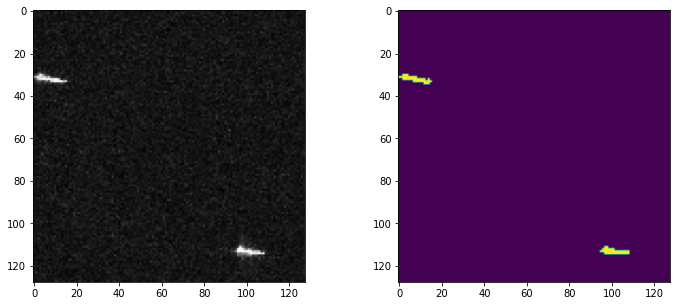

In [26]:
img, mask = train_data[22]
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(TF.to_pil_image(img))
plt.subplot(122)
plt.imshow(mask.squeeze())
plt.show()

In [ ]:
x, y = next(iter(train_dl))
print(x.shape, y.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([64, 3, 512, 512]) torch.Size([64, 1, 512, 512])


# U-Net from scratch

In [33]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as tf

In [35]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features = [64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.down = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Down part
        for feature in features:
            self.down.append(DoubleConv(in_channels, feature))
            in_channels = feature

        #Up part
        for feature in features[::-1]:
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottle_neck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for dw in self.down:
            x = dw(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottle_neck(x)
        skip_connections = skip_connections[::-1]

        for id in range(0, len(self.ups), 2):
            x = self.ups[id](x)
            sk_cn = skip_connections[id//2]

            if x.shape != sk_cn.shape:
                x = tf.resize(x, size=sk_cn.shape[2:])

            concat_skip = torch.cat((sk_cn, x), dim=1)
            x = self.ups[id+1](concat_skip)

        x = self.final_conv(x)
        return x

## Training part

In [36]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.float().to(device=DEVICE)
        targets = targets.float().to(device=DEVICE)

        logits = model(data)
        loss = loss_fn(logits, targets)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())

In [ ]:
model = UNet(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
scaler = torch.cuda.amp.GradScaler()

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.float().to(device)
            y = y.float().to(device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels * 100:.2f}"
    )
    print (f"Dice score: {dice_score/len(loader)}")
    model.train()

In [ ]:
for epoch in range(NUM_EPOCHS):
    print(f"Epoch number: {epoch + 1}\n")
    train_fn(train_dl, model, optimizer, loss_fn, scaler)

    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),

    }

    check_accuracy(valid_dl, model, device=DEVICE)

Epoch number: 1



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/455 [00:00<?, ?it/s]

Got 128048417/128516096 with acc 99.64
Dice score: 0.3345920145511627
Epoch number: 2



  0%|          | 0/455 [00:00<?, ?it/s]

Got 128041370/128516096 with acc 99.63
Dice score: 0.35109061002731323
Epoch number: 3



  0%|          | 0/455 [00:00<?, ?it/s]

Got 128090173/128516096 with acc 99.67
Dice score: 0.6899673342704773
Epoch number: 4



  0%|          | 0/455 [00:00<?, ?it/s]

Got 128120669/128516096 with acc 99.69
Dice score: 0.6735919713973999
Epoch number: 5



  0%|          | 0/455 [00:00<?, ?it/s]

Got 128120540/128516096 with acc 99.69
Dice score: 0.7075744271278381
Epoch number: 6



  0%|          | 0/455 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc230163200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc230163200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Got 128086013/128516096 with acc 99.67
Dice score: 0.6333222985267639
Epoch number: 7



  0%|          | 0/455 [00:00<?, ?it/s]

Got 128117485/128516096 with acc 99.69
Dice score: 0.765259861946106
Epoch number: 8



  0%|          | 0/455 [00:00<?, ?it/s]

Got 128135292/128516096 with acc 99.70
Dice score: 0.6906921863555908
Epoch number: 9



  0%|          | 0/455 [00:00<?, ?it/s]

Got 128131422/128516096 with acc 99.70
Dice score: 0.7241460084915161
Epoch number: 10



  0%|          | 0/455 [00:00<?, ?it/s]

Got 128027541/128516096 with acc 99.62
Dice score: 0.2426011860370636


In [ ]:
torch.save(model, './based_unet.pth')

# Pretrained U-Net with ResNet-50 encoder on ImageNet

In [27]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 1
ACTIVATION = 'sigmoid'

In [ ]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASSES, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
model

In [ ]:
loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

In [ ]:
trainSteps = len(train_dl) // BATCH_SIZE
testSteps = len(valid_dl) // BATCH_SIZE

H = {"train_loss": [], "test_loss": []}

In [ ]:
%%time

for e in tqdm(range(NUM_EPOCHS)):
	model.train()

	totalTrainLoss = 0
	totalTestLoss = 0

	for (i, (x, y)) in enumerate(tqdm(train_dl)):
		(x, y) = (x.float().to(DEVICE), y.float().to(DEVICE))
		pred = model(x)
		loss_val = loss(pred, y)
		optimizer.zero_grad()
		loss_val.backward()
		optimizer.step()
		totalTrainLoss += loss_val

	with torch.no_grad():
		model.eval()
		for (x, y) in valid_dl:
			(x, y) = (x.float().to(DEVICE), y.float().to(DEVICE))
			pred = model(x)
			totalTestLoss += loss(pred, y)

	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [ ]:
torch.save(model, './unet_resnet50_imagenet.pth')

# Pretrained U-Net++ with ResNet-50 on swsl

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'swsl'
CLASSES = 1
ACTIVATION = 'sigmoid'

In [ ]:
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASSES, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnet50-16a12f1b.pth" to /root/.cache/torch/hub/checkpoints/semi_weakly_supervised_resnet50-16a12f1b.pth


  0%|          | 0.00/97.7M [00:00<?, ?B/s]

In [ ]:
model

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [ ]:
loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.AdamW([ 
    dict(params=model.parameters(), lr=LEARNING_RATE),
])

In [28]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=1):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): 
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: 
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [29]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(DEVICE)

    for e in tqdm(range(epochs)):
        running_loss = 0
        iou_score = 0
        accuracy = 0

        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            image_tiles, mask_tiles = data
            
            image = image_tiles.float().to(DEVICE); mask = mask_tiles.float().to(DEVICE);
            output = model(image)

            loss = criterion(output, mask)
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            loss.backward()
            optimizer.step()          
            optimizer.zero_grad() 
            
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0

            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data
                    
                    image = image_tiles.float().to(DEVICE); mask = mask_tiles.float().to(DEVICE);
                    output = model(image)
  
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)

                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))

            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                    
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    return history

In [ ]:
max_lr = 1e-3
epoch = 10
weight_decay = 1e-4

criterion = loss
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, LEARNING_RATE, epochs=epoch,
                                            steps_per_epoch=len(train_dl))

history = fit(epoch, model, train_dl, valid_dl, criterion, optimizer, sched)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.978 
Epoch:1/10.. Train Loss: 0.988.. Val Loss: 0.978.. Train mIoU:0.498.. Val mIoU: 0.498.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. 0.978 >> 0.901 
Epoch:2/10.. Train Loss: 0.950.. Val Loss: 0.901.. Train mIoU:0.498.. Val mIoU: 0.498.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. 0.901 >> 0.323 
Epoch:3/10.. Train Loss: 0.575.. Val Loss: 0.323.. Train mIoU:0.498.. Val mIoU: 0.500.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. 0.323 >> 0.269 
saving model...
Epoch:4/10.. Train Loss: 0.328.. Val Loss: 0.269.. Train mIoU:0.498.. Val mIoU: 0.498.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. 0.269 >> 0.238 
Epoch:5/10.. Train Loss: 0.294.. Val Loss: 0.238.. Train mIoU:0.498.. Val mIoU: 0.498.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch:6/10.. Train Loss: 0.285.. Val Loss: 0.239.. Train mIoU:0.498.. Val mIoU: 0.498.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. 0.238 >> 0.236 
Epoch:7/10.. Train Loss: 0.267.. Val Loss: 0.236.. Train mIoU:0.498.. Val mIoU: 0.498.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. 0.236 >> 0.219 
Epoch:8/10.. Train Loss: 0.257.. Val Loss: 0.219.. Train mIoU:0.498.. Val mIoU: 0.498.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. 0.219 >> 0.218 
Epoch:9/10.. Train Loss: 0.249.. Val Loss: 0.218.. Train mIoU:0.498.. Val mIoU: 0.498.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch:10/10.. Train Loss: 0.250.. Val Loss: 0.221.. Train mIoU:0.498.. Val mIoU: 0.498.. Train Acc:0.997.. Val Acc:0.996..


In [ ]:
torch.save(model, './unet++_resnet50_imagenet_swsl.pth')

# Pretrained DeepLabV3

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 1
ACTIVATION = 'sigmoid'

In [ ]:
model = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASSES, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model

DeepLabV3(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [ ]:
loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.AdamW([ 
    dict(params=model.parameters(), lr=LEARNING_RATE),
])

In [ ]:
epoch = 10
weight_decay = 1e-4

criterion = loss
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, LEARNING_RATE, epochs=epoch,
                                            steps_per_epoch=len(train_dl))

history_v3 = fit(epoch, model, train_dl, valid_dl, criterion, optimizer, sched)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.980 
Epoch:1/10.. Train Loss: 0.986.. Val Loss: 0.980.. Train mIoU:0.498.. Val mIoU: 0.498.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. 0.980 >> 0.747 
Epoch:2/10.. Train Loss: 0.903.. Val Loss: 0.747.. Train mIoU:0.498.. Val mIoU: 0.498.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. 0.747 >> 0.582 
Epoch:3/10.. Train Loss: 0.658.. Val Loss: 0.582.. Train mIoU:0.498.. Val mIoU: 0.498.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. 0.582 >> 0.541 
Epoch:4/10.. Train Loss: 0.572.. Val Loss: 0.541.. Train mIoU:0.498.. Val mIoU: 0.500.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. 0.541 >> 0.519 
Epoch:5/10.. Train Loss: 0.545.. Val Loss: 0.519.. Train mIoU:0.498.. Val mIoU: 0.498.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. 0.519 >> 0.501 
Epoch:6/10.. Train Loss: 0.517.. Val Loss: 0.501.. Train mIoU:0.498.. Val mIoU: 0.500.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. 0.501 >> 0.490 
Epoch:7/10.. Train Loss: 0.497.. Val Loss: 0.490.. Train mIoU:0.498.. Val mIoU: 0.498.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. 0.490 >> 0.481 
Epoch:8/10.. Train Loss: 0.489.. Val Loss: 0.481.. Train mIoU:0.498.. Val mIoU: 0.498.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. 0.481 >> 0.480 
Epoch:9/10.. Train Loss: 0.479.. Val Loss: 0.480.. Train mIoU:0.498.. Val mIoU: 0.500.. Train Acc:0.997.. Val Acc:0.996..


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Loss Decreasing.. 0.480 >> 0.475 
Epoch:10/10.. Train Loss: 0.474.. Val Loss: 0.475.. Train mIoU:0.498.. Val mIoU: 0.498.. Train Acc:0.997.. Val Acc:0.996..


In [ ]:
torch.save(model, './deeplab_resnet50_imagenet.pth')

# Evaluation

In [30]:
device = DEVICE
import torch.nn.functional as F
from torchvision import transforms as T
from PIL import Image

In [85]:
def predict_image_mask_miou(model, image, mask):
    model.eval()
    model.to(device); image=image.float().to(device)
    mask = mask.float().to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [40]:
def predict_image_mask_pixel(model, image, mask):
    model.eval()
    model.to(device); image=image.float().to(device)
    mask = mask.float().to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [41]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [42]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

## 1.1 UNet with ResNet pretrained

In [89]:
model_1 = torch.load('./unet_resnet50_imagenet.pth')

In [90]:
image, mask = test_data[3]
pred_mask, score = predict_image_mask_miou(model_1, image, mask)

In [91]:
mob_miou = miou_score(model_1, test_data)

  0%|          | 0/461 [00:00<?, ?it/s]

In [92]:
mob_acc = pixel_acc(model_1, test_data)

  0%|          | 0/461 [00:00<?, ?it/s]

In [ ]:
img = image.swapaxes(0,1)
img = img.swapaxes(1,2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Picture');

ax2.imshow(np.squeeze(mask))
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-resnet50 | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [94]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.9892568857188856


In [95]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.9892966049095038


## 1.2 UNet++ with Resnet50

In [111]:
model_2 = torch.load('./unet++_resnet50_imagenet_swsl.pth')

In [112]:
image, mask = test_data[3]
pred_mask, score = predict_image_mask_miou(model_2, image, mask)

In [ ]:
img = image.swapaxes(0,1)
img = img.swapaxes(1,2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Picture');

ax2.imshow(np.squeeze(mask))
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet++-resnet50 | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [114]:
mob_miou_2 = miou_score(model_2, test_data)

  0%|          | 0/461 [00:00<?, ?it/s]

In [115]:
mob_acc_2 = pixel_acc(model_2, test_data)

  0%|          | 0/461 [00:00<?, ?it/s]

In [116]:
print('Test Set mIoU', np.mean(mob_miou_2))

Test Set mIoU 0.9886816194414316


In [117]:
print('Test Set Pixel Accuracy', np.mean(mob_acc_2))

Test Set Pixel Accuracy 0.9893507554060467


## 1.3 DeepLabV3 with Resnet50

In [97]:
model_3 = torch.load('./deeplab_resnet50_imagenet.pth')

In [98]:
image, mask = test_data[3]
pred_mask, score = predict_image_mask_miou(model_3, image, mask)

In [ ]:
img = image.swapaxes(0,1)
img = img.swapaxes(1,2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Picture');

ax2.imshow(np.squeeze(mask))
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('DeepLabV3-resnet50 | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [100]:
mob_miou_3 = miou_score(model_3, test_data)

  0%|          | 0/461 [00:00<?, ?it/s]

In [101]:
mob_acc_3 = pixel_acc(model_3, test_data)

  0%|          | 0/461 [00:00<?, ?it/s]

In [102]:
print('Test Set mIoU', np.mean(mob_miou_3))

Test Set mIoU 0.9889277460259626


In [103]:
print('Test Set Pixel Accuracy', np.mean(mob_acc_3))

Test Set Pixel Accuracy 0.9890343258541214


## 1.4 Unet from scratch

In [104]:
model = torch.load('./based_unet.pth')

In [105]:
image, mask = test_data[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [ ]:
img = image.swapaxes(0,1)
img = img.swapaxes(1,2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Picture');

ax2.imshow(np.squeeze(mask))
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-scratch | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [107]:
mob_miou_4 = miou_score(model, test_data)

  0%|          | 0/461 [00:00<?, ?it/s]

In [108]:
mob_acc_4 = pixel_acc(model, test_data)

  0%|          | 0/461 [00:00<?, ?it/s]

In [109]:
print('Test Set mIoU', np.mean(mob_miou_4))

Test Set mIoU 0.98883506791452


In [110]:
print('Test Set Pixel Accuracy', np.mean(mob_acc_4))

Test Set Pixel Accuracy 0.9890527290791079


# Summary


По результатам сравнения лучше всего себя показала модели UNet и UNet++ с предобученным ResNet-50 энкодером, выбив метрику `mIoU = 98.92%` и `accuracy = 98.93%`. Дальнейшее иследование следует проводить с этими двумя моделями, подбирая гиперпараметры и докручивая архитектуру.